# 두 번째 모델 훈련하기

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
np.random.seed(35)

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    train_vectorizer, 
    get_vectorized_series,
    get_feature_vector_and_label,
    add_text_features_to_df
)
from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)

from ml_editor.model_v2 import (
    add_char_count_features, 
    get_word_stats, 
    get_sentiment_score, 
    POS_NAMES,
    get_question_score_from_input,
    add_v2_text_features
)

data_path = Path('./data/processed/writers/writers.csv')
df = pd.read_csv(data_path, index_col=0)
df = format_raw_df(df.copy())
df = df.loc[df["is_question"]].copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#df = add_text_features_to_df(df.copy())
#df = add_v2_text_features(df.copy())
#df.to_csv("./data/processed/writers/writers_with_features.csv")

100%|███████████████████████████████████████████████████████████████████████████| 11302/11302 [00:24<00:00, 454.03it/s]


In [19]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")


새로운 모델에 도움이 될만한 후보 특성을 추가한다.

In [7]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [8]:
vectorizer = train_vectorizer(train_df)
df["vectors"] = get_vectorized_series(df["full_text"].copy(), vectorizer)

In [9]:
df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|███████████████████████████████████████████████████████████████████████████| 11302/11302 [00:22<00:00, 494.73it/s]


In [6]:
feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

# 모델

In [7]:
# 특성을 새로 추가했으므로 데이터셋을 다시 나눕니다.
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [8]:
X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [9]:
y_train.value_counts()

False    5239
True     3985
Name: Score, dtype: int64

In [10]:
X_test.shape

(2078, 9496)

In [11]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

In [12]:
def get_metrics(y_test, y_predicted):  
    # 진짜 양성 / (진짜 양성 + 가짜 양성)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # 진짜 양성 / (진짜 양성 + 가짜 음성)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # 정밀도와 재현율의 조화 평균
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # 진짜 양성 + 진짜 음성 / 전체
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# 훈련 정확도
# https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method 참고
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("훈련 정확도 = %.3f, 정밀도 = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

훈련 정확도 = 0.609, 정밀도 = 0.572, recall = 0.378, f1 = 0.455


In [13]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("검증 정확도 = %.3f, 정밀도 = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

검증 정확도 = 0.621, 정밀도 = 0.593, recall = 0.381, f1 = 0.464


In [14]:
model_path = Path("./models/model_2.pkl")
vectorizer_path = Path("./models/vectorizer_2.pkl")
joblib.dump(clf, model_path) 
joblib.dump(vectorizer, vectorizer_path) 

['models\\vectorizer_2.pkl']

# 특성의 유용성 검증

In [15]:
# vectorize를 통해 생성된 feature + 추가한 feature
w_indices = vectorizer.get_feature_names()
w_indices.extend(feature_arr)
all_feature_names = np.array(w_indices)

In [16]:
list(df["spacy_text"][1])

[What,
 are,
 some,
 online,
 guides,
 for,
 starting,
 writers,
 ?,
 I,
 've,
 always,
 wanted,
 to,
 start,
 writing,
 (,
 in,
 a,
 totally,
 amateur,
 way,
 ),
 ,,
 but,
 whenever,
 I,
 want,
 to,
 start,
 something,
 I,
 instantly,
 get,
 blocked,
 having,
 a,
 lot,
 of,
 questions,
 and,
 doubts,
 .,
 ,
 Are,
 there,
 some,
 resources,
 on,
 how,
 to,
 start,
 becoming,
 a,
 writer,
 ?,
 ,
 I,
 'm,
 thinking,
 something,
 with,
 tips,
 and,
 easy,
 exercises,
 to,
 get,
 the,
 ball,
 rolling,
 .,
 ]

In [17]:
[token.pos_ for token in df["spacy_text"][1]]

['PRON',
 'AUX',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'VERB',
 'NOUN',
 'PUNCT',
 'PRON',
 'AUX',
 'ADV',
 'VERB',
 'PART',
 'VERB',
 'VERB',
 'PUNCT',
 'ADP',
 'DET',
 'ADV',
 'ADJ',
 'NOUN',
 'PUNCT',
 'PUNCT',
 'CCONJ',
 'ADV',
 'PRON',
 'VERB',
 'PART',
 'VERB',
 'PRON',
 'PRON',
 'ADV',
 'VERB',
 'VERB',
 'VERB',
 'DET',
 'NOUN',
 'ADP',
 'NOUN',
 'CCONJ',
 'NOUN',
 'PUNCT',
 'SPACE',
 'AUX',
 'PRON',
 'DET',
 'NOUN',
 'ADP',
 'ADV',
 'PART',
 'VERB',
 'VERB',
 'DET',
 'NOUN',
 'PUNCT',
 'SPACE',
 'PRON',
 'AUX',
 'VERB',
 'PRON',
 'ADP',
 'NOUN',
 'CCONJ',
 'ADJ',
 'NOUN',
 'PART',
 'AUX',
 'DET',
 'NOUN',
 'NOUN',
 'PUNCT',
 'SPACE']

In [18]:
k = 20
print("상위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\n하위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

상위 20개 중요도:

num_chars: 0.0076
num_diff_words: 0.0073
num_periods: 0.007
num_questions: 0.0068
ADJ: 0.0066
ADV: 0.0065
PUNCT: 0.0064
num_commas: 0.0063
DET: 0.0061
AUX: 0.0059
avg_word_len: 0.0059
VERB: 0.0059
NOUN: 0.0056
polarity: 0.0056
ADP: 0.0055
SCONJ: 0.0055
num_stops: 0.0054
num_words: 0.0053
PART: 0.0053
PRON: 0.0052

하위 20개 중요도:

plug: 0
prefers: 0
closure: 0
climaxes: 0
preaching: 0
pray: 0
clip: 0
pr: 0
powerless: 0
closeness: 0
cloth: 0
coherence: 0
posing: 0
portrayals: 0
pond: 0
cms: 0
coastal: 0
poking: 0
coding: 0
pitched: 0


새로 만든 특성이 가장 예측 성능이 좋은 편인 것을 확인할 수 있다.     
반대로 TF-IDF 벡터화로 얻은 단어 벡터는 특별히 도움이 되지 않는다.

# 예측과 데이터 비교하기

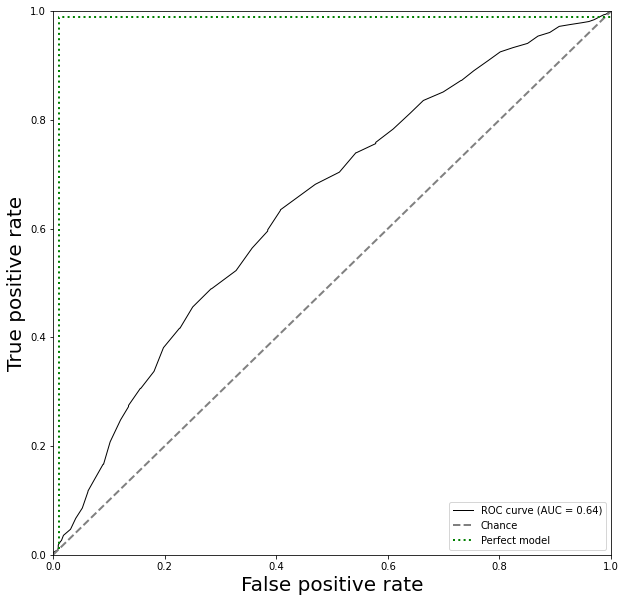

In [19]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

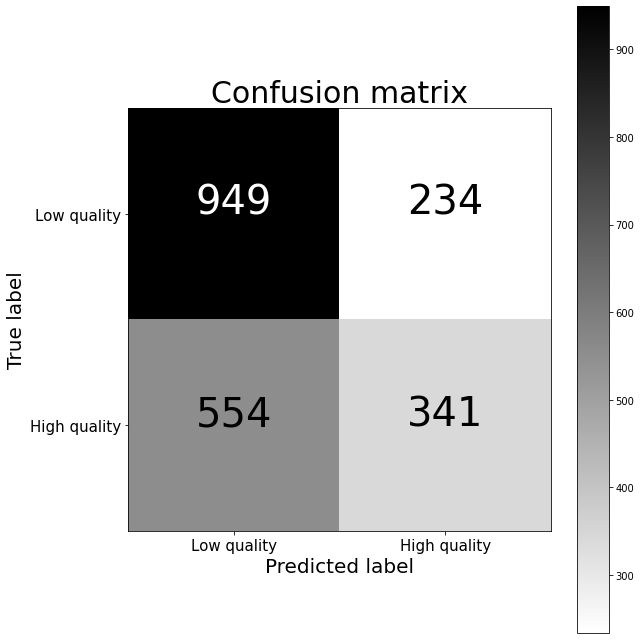

In [20]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	Brier: 0.231


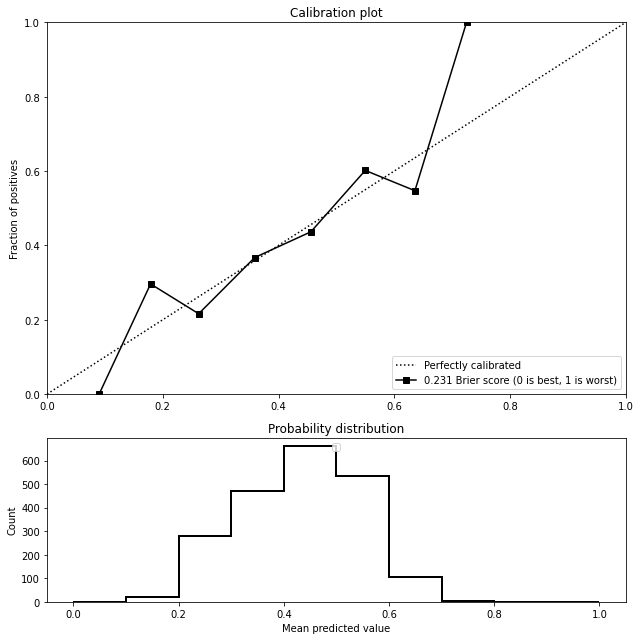

In [21]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

# 추론 함수

첫 번째 모델과 마찬가지로 임의의 질문을 받고 높은 점수를 받을 추정 확률을 출력하는 추론 함수를 정의

In [22]:
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]

0.26 probability of the question receiving a high score according to our model
